In [10]:
%matplotlib widget

import os
import sys
import matplotlib.pyplot as plt
from IPython import embed
import pickle
import torch
import yaml
import pandas as pd

sys.path.append(os.path.abspath("/develop/code/surrogate_model/src"))
from core import datamodule, model
from utils import parameter_manager

params = yaml.load(open('../config.yaml', 'r'), Loader = yaml.FullLoader)
pm = parameter_manager.ParameterManager(params = params)

network = model.SurrogateModel(pm.params_model)
results_path = "/develop/results/spie_journal_2023"
exp_name = "charlie"

In [2]:
def find_checkpoints(path):
    v0 = []
    v1 = []
    sorted_files = sorted(os.listdir(path))
    for entry in sorted_files:
        if "v1" in entry:
            v1.append(entry)

        else:
            v0.append(entry)
                
    return v0, v1

def sort_list(list):
    idxs = []
    for item in list:
        if "v1" not in item:
            if '=' in item:
                idx = item.split('=')[1].split('.')[0]
                idxs.append(int(idx))
                
            else:
                temp = item
                list.remove(item)

        else:
            if '=' in item:
                idx = item.split('=')[1].split('-')[0]
                idxs.append(int(idx))
            else:
                temp = item
                list.remove(item)

    sorted_pairs = sorted(zip(idxs,list), key=lambda x: x[0])
    sorted_list = [name for _, name in sorted_pairs]
    sorted_list.append(temp)
            
    return sorted_list

In [3]:
path_first = os.path.join(results_path, exp_name + "_0", "checkpoints") # first 100 epochs
path_second = os.path.join(results_path, exp_name + "_1", "checkpoints") # last 700 epochs

v0_0, v1_0 = find_checkpoints(path_first) # get v0 and v1 from charlie_0 - first 100 epochs

sorted_v0_0 = sort_list(v0_0)
sorted_v1_0 = sort_list(v1_0)

v0_1, v1_1 = find_checkpoints(path_second) # get v0 and v1 from charlie_1 - remaining epochs
sorted_v0_1 = sort_list(v0_1)
sorted_v1_1 = sort_list(v1_1)

In [4]:
state_dicts_0 = []
for item in sorted_v0_0: # v0, first 100 epochs
    checkpoint_path = os.path.join(path_first, item)
    temp = torch.load(checkpoint_path)
    state_dict = temp['state_dict']
    network.load_state_dict(state_dict)
    state_dicts_0.append(network)

for item in sorted_v0_1: # v0, last 700 epochs
    checkpoint_path = os.path.join(path_second, item)
    temp = torch.load(checkpoint_path)
    state_dict = temp['state_dict']
    network.load_state_dict(state_dict)
    state_dicts_0.append(network)

In [5]:
state_dicts_1 = []
for item in sorted_v1_0: # v1, first 100 epochs)
    checkpoint_path = os.path.join(path_first, item)
    temp = torch.load(checkpoint_path)
    state_dict = temp['state_dict']
    network.load_state_dict(state_dict)
    state_dicts_1.append(network)
for item in sorted_v1_1: # v1, last 700 epochs
    checkpoint_path = os.path.join(path_second, item)
    temp = torch.load(checkpoint_path)
    state_dict = temp['state_dict']
    network.load_state_dict(state_dict)
    state_dicts_1.append(network)

In [6]:
print(len(state_dicts_0), len(state_dicts_1))

36 26


In [20]:
def plot_loss(path):

    loss = load_loss(path)
    plt.style.use("ggplot")
    
    fig, ax = plt.subplots()
    
    fig.suptitle("Phase loss")

    labels = ["Train", "Valid"]
    linestyles = ['solid', 'dotted', 'dashdot']
    colors = ['darkgreen','purple','#4e88d9'] 
    # train dataset

    x_vals = loss['epoch']
    y_vals = loss['train_phase_loss']
    x_vals = x_vals[x_vals.index % 2 != 0]
    y_vals = y_vals[y_vals.index % 2 != 0]
    
    ax.plot(x_vals, y_vals, label=labels[0], c=colors[0])
    ax.legend()
    
    # val dataset
    x_vals = loss['epoch']
    y_vals = loss['val_phase_loss']
    x_vals = x_vals[x_vals.index % 2 == 0]
    y_vals = y_vals[y_vals.index % 2 == 0]
    
    ax.plot(x_vals, y_vals, label=labels[1], c=colors[1])
    ax.legend()

def is_csv_empty(path):
    try:
        df = pd.read_csv(path)
        if df.empty:
            return True
    except pd.errors.EmptyDataError:
        return True

    return False

def load_loss(path):
    if is_csv_empty(path):
        print("Empty CSV file")
        return False
    else:
        return pd.read_csv(path)

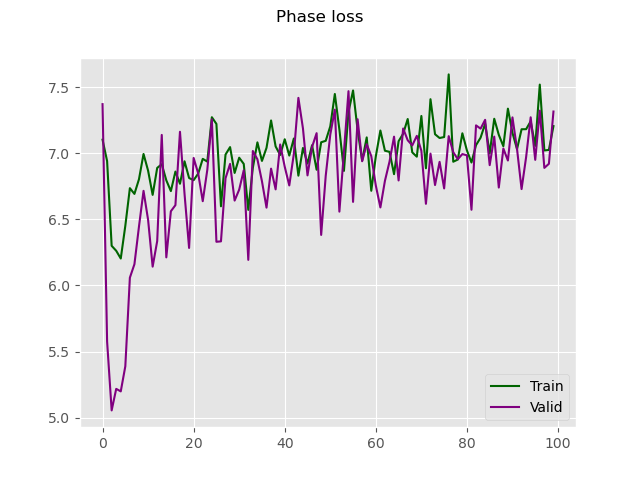

In [21]:
# v0, using lr = 1e-8
plot_loss(os.path.join(results_path, "charlie_0", "loss.csv"))

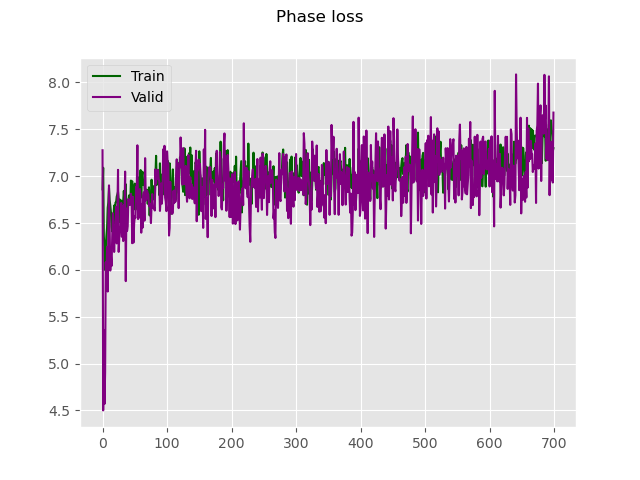

In [22]:
plot_loss(os.path.join(results_path, "charlie_1", "loss.csv"))